## 9. Identifying "Smart Shoppers" (High Promo + High Spend)

Now we create a **2×2 matrix** to segment households along two dimensions:

1. **Promotion usage** (heavy vs. light)
2. **Spending level** (high vs. low)

This creates four distinct groups:

| | **Low Spend** | **High Spend** |
|------------------|--------------------------|---------------------------|
| **Promo-Heavy** | "Margin Killers" | **"Smart Shoppers"** |
| **Promo-Light** | "Low Value" | "Untapped Potential" |

Our primary focus: **Smart Shoppers** (promo-heavy + high-spend)
- Do they exist in meaningful numbers?
- What are their characteristics?
- Should we invest MORE in promotions for this segment?


In [29]:

spend_threshold = households['total_sales'].quantile(0.75)

households['spend_segment'] = np.where(
    households['total_sales'] >= spend_threshold,
    'high_spend',
    'low_spend'
)

threshold_df = pd.DataFrame({
    'Threshold': ['High-Spend (Top 25%)'],
    'Value': [f'${spend_threshold:.2f}']
})
display(threshold_df.set_index('Threshold'))
print("\nSpend segment distribution:")
print(households['spend_segment'].value_counts())



,Value
Threshold,
High-Spend (Top 25%),$2536.15



Spend segment distribution:
spend_segment
low_spend     1851
high_spend     618
Name: count, dtype: int64


In [30]:

households['shopper_type'] = (
    households['promo_segment'] + ' & ' + households['spend_segment']
)

print("\n" + "=" * 80)
print("2×2 SHOPPER TYPE MATRIX")

shopper_type_counts = households['shopper_type'].value_counts()
print("\nDistribution:")
for shopper_type, count in shopper_type_counts.items():
    pct = count / len(households) * 100




2×2 SHOPPER TYPE MATRIX

Distribution:


In [31]:

shopper_summary = (
    households
    .groupby('shopper_type')
    .agg(
        num_households=('household_id', 'nunique'),
        mean_total_sales=('total_sales', 'mean'),
        mean_avg_basket=('avg_basket_value', 'mean'),
        mean_num_trips=('num_trips', 'mean'),
        mean_discount_share=('discount_share', 'mean'),
        mean_coupons_per_100=('coupons_per_100_items', 'mean')
    )
    .round(2)
)

if 'avg_price_per_unit' in households.columns:
    shopper_summary['mean_avg_price_unit'] = (
        households.groupby('shopper_type')['avg_price_per_unit'].mean().round(2)
    )

print("\nMetrics by shopper type:")
display(shopper_summary)




Metrics by shopper type:


,num_households,mean_total_sales,mean_avg_basket,mean_num_trips,mean_discount_share,mean_coupons_per_100,mean_avg_price_unit
shopper_type,,,,,,,
promo_heavy & high_spend,238,4574.30,42.26,138.46,0.58,0.45,0.37
promo_heavy & low_spend,529,975.72,28.48,40.22,0.62,0.13,1.17
promo_light & high_spend,380,4631.33,45.10,127.17,0.46,0.04,0.84
promo_light & low_spend,1322,931.39,27.53,40.31,0.45,0.00,1.52


In [32]:

smart_shoppers = households['shopper_type'] == 'promo_heavy & high_spend'
num_smart = smart_shoppers.sum()
pct_smart = num_smart / len(households) * 100

print("\n" + "=" * 80)
print("SMART SHOPPERS ANALYSIS")


smart_vs_others = (
    households
    .assign(is_smart_shopper=smart_shoppers)
    .groupby('is_smart_shopper')
    .agg(
        num_households=('household_id', 'nunique'),
        mean_total_sales=('total_sales', 'mean'),
        mean_avg_basket=('avg_basket_value', 'mean'),
        mean_discount_share=('discount_share', 'mean'),
        mean_coupons_per_100=('coupons_per_100_items', 'mean')
    )
    .round(2)
)

if 'avg_price_per_unit' in households.columns:
    smart_vs_others['mean_avg_price_unit'] = (
        households
        .assign(is_smart_shopper=smart_shoppers)
        .groupby('is_smart_shopper')['avg_price_per_unit']
        .mean()
        .round(2)
    )

smart_vs_others.index = ['All Others', 'Smart Shoppers']

print("\nSmart Shoppers vs. Rest of Population:")
display(smart_vs_others)

smart_basket = smart_vs_others.loc['Smart Shoppers', 'mean_avg_basket']
others_basket = smart_vs_others.loc['All Others', 'mean_avg_basket']
basket_lift = ((smart_basket - others_basket) / others_basket) * 100

smart_sales = smart_vs_others.loc['Smart Shoppers', 'mean_total_sales']
others_sales = smart_vs_others.loc['All Others', 'mean_total_sales']
sales_lift = ((smart_sales - others_sales) / others_sales) * 100

print("\n📊 Smart Shoppers vs. Everyone Else:")
smart_metrics_df = pd.DataFrame({
    'Metric': ['Basket Value Lift', 'Annual Spending Lift', 'Discount Usage'],
    'Value': [
        f'+{basket_lift:.1f}%',
        f'+{sales_lift:.1f}%',
        f"{smart_vs_others.loc['Smart Shoppers', 'mean_discount_share']:.1%}"
    ]
})
display(smart_metrics_df.set_index('Metric'))




SMART SHOPPERS ANALYSIS

Smart Shoppers vs. Rest of Population:


,num_households,mean_total_sales,mean_avg_basket,mean_discount_share,mean_coupons_per_100,mean_avg_price_unit
All Others,2231,1572.10,30.75,0.49,0.04,1.32
Smart Shoppers,238,4574.30,42.26,0.58,0.45,0.37



📊 Smart Shoppers vs. Everyone Else:


,Value
Metric,
Basket Value Lift,+37.4%
Annual Spending Lift,+191.0%
Discount Usage,58.0%


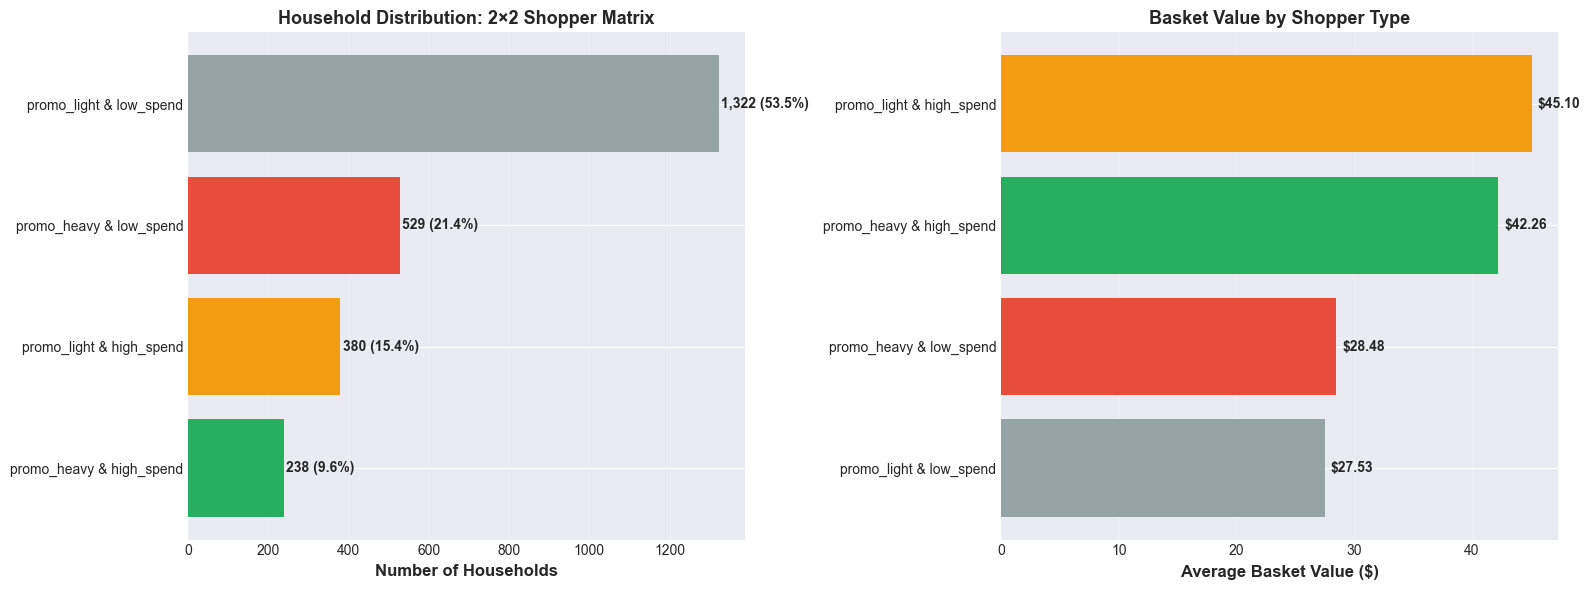

In [33]:

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axes[0]
colors_map = {
    'promo_heavy & high_spend': '#27ae60',
    'promo_heavy & low_spend': '#e74c3c',
    'promo_light & high_spend': '#f39c12',
    'promo_light & low_spend': '#95a5a6'
}

sorted_types = shopper_type_counts.sort_values(ascending=True)
colors = [colors_map.get(x, '#3498db') for x in sorted_types.index]

bars = ax1.barh(range(len(sorted_types)), sorted_types.values, color=colors)
ax1.set_yticks(range(len(sorted_types)))
ax1.set_yticklabels(sorted_types.index)
ax1.set_xlabel('Number of Households', fontsize=12, fontweight='bold')
ax1.set_title('Household Distribution: 2×2 Shopper Matrix', fontsize=13, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars, sorted_types.values)):
    pct = val / len(households) * 100
    ax1.text(val + 5, i, f'{val:,} ({pct:.1f}%)', 
             va='center', fontsize=10, fontweight='bold')

ax2 = axes[1]
basket_by_type = shopper_summary['mean_avg_basket'].sort_values(ascending=True)
colors2 = [colors_map.get(x, '#3498db') for x in basket_by_type.index]

bars2 = ax2.barh(range(len(basket_by_type)), basket_by_type.values, color=colors2)
ax2.set_yticks(range(len(basket_by_type)))
ax2.set_yticklabels(basket_by_type.index)
ax2.set_xlabel('Average Basket Value ($)', fontsize=12, fontweight='bold')
ax2.set_title('Basket Value by Shopper Type', fontsize=13, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)

for i, (bar, val) in enumerate(zip(bars2, basket_by_type.values)):
    ax2.text(val + 0.5, i, f'${val:.2f}', 
             va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('./final_project_output/shopper_type_matrix.png', dpi=300, bbox_inches='tight')
plt.show()



In [34]:

print("\n" + "=" * 80)
print("DEMOGRAPHIC PROFILE: SMART SHOPPERS")

smart_shopper_households = households[smart_shoppers]

if 'income' in households.columns:
    print("\nIncome distribution:")
    smart_income = smart_shopper_households['income'].value_counts(dropna=True).sort_index()
    for income, count in smart_income.items():
        pct = count / len(smart_shopper_households) * 100
    
    print("\n  → Most common income among smart shoppers:", smart_income.idxmax())

if 'has_kids' in households.columns:
    print("\nHousehold composition:")
    smart_kids = smart_shopper_households['has_kids'].value_counts()
    for has_kids, count in smart_kids.items():
        pct = count / len(smart_shopper_households) * 100
        label = "With kids" if has_kids == 1 else "No kids"

if 'age' in households.columns:
    print("\nAge distribution:")
    smart_age = smart_shopper_households['age'].value_counts(dropna=True).sort_index()
    for age, count in smart_age.items():
        pct = count / len(smart_shopper_households) * 100

if 'household_size' in households.columns:
    print("\nHousehold size:")
    smart_size = smart_shopper_households['household_size'].value_counts(dropna=True).sort_index()
    for size, count in smart_size.items():
        pct = count / len(smart_shopper_households) * 100




DEMOGRAPHIC PROFILE: SMART SHOPPERS

Income distribution:

  → Most common income among smart shoppers: 50-74K

Household composition:

Age distribution:

Household size:
